In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import math
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import numba
from numba import jit, int32, int64, float32, float64
import timeit
import time
import pstats

In [2]:
%load_ext cython

In [3]:
#iris = sns.load_dataset('iris')

# matrix data
#X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
#specs = np.array(iris['species'])

In [4]:
X = np.loadtxt("Data/mnist2500_X.txt")
labels = np.loadtxt("Data/mnist2500_labels.txt")
small = X[:50]
small.shape

(50, 784)

## Original Code

In [5]:
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows.
    Output is a pairwise distance matrix D that is nxn.
    """
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D


def p_cond(d_matrix, sigmas):
    """Convert a distances matrix to a matrix of conditional probabilities."""

    sig_2 = np.square(sigmas.reshape((-1, 1)))
    P_cond = np.exp((d_matrix / (2 * sig_2)) - np.max((d_matrix / (2 * sig_2)), axis=1).reshape([-1, 1]))

    # set p_i|i = 0
    np.fill_diagonal(P_cond, 0.)

    P_cond = (P_cond + 1e-10) / (P_cond + 1e-10).sum(axis=1).reshape([-1, 1])

    return P_cond


def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        mid = (lower + upper) / 2.
        val = eval_fn(mid)
        if val > target:
            upper = mid
        else:
            lower = mid
        if np.abs(val - target) <= tol:
            break
    return mid


def perp(d_matrix, sigmas):
    """calculate perplexity from distance matrix, sigmas, and conditional probability matrix."""
    P = p_cond(d_matrix, sigmas)
    entropy = -np.sum(P * np.log2(P), axis=1)
    perplexity = 2 ** entropy

    return perplexity


def find_optimal_sigmas(d_matrix, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = []
    # For each row of the matrix (each point in our dataset)
    for i in range(d_matrix.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perp(d_matrix[i:i + 1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)


def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""

    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)

    # q_i|i = 0
    np.fill_diagonal(Q, 0.)

    return Q


def p_ij(X, target_perplexity):
    """Calculate joint probabilities in the high dimensional space given data matrix X
    and a target perplexity to find optimal sigmas (pg. 2584).
    """

    d_matrix = -squared_euc_dist(X)

    # optimal sigma for each row of distance matrix
    sigmas = find_optimal_sigmas(d_matrix, target_perplexity)

    # conditional p matrix from optimal sigmas
    p_conditional = p_cond(d_matrix, sigmas)

    # convert conditional P to joint P matrix (pg. 2584)
    n = p_conditional.shape[0]
    p_joint = (p_conditional + p_conditional.T) / (2. * n)

    return p_joint


def grad_C(P, Q, Y):
    """Calculate gradient of cost function (KL) with respect to lower dimensional map points Y (pg. 2586)"""

    pq_diff = (P - Q)[:, :, np.newaxis]

    y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]

    y_dist = (np.power(1. + (squared_euc_dist(Y)), -1))[:, :, np.newaxis]

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis=1)

    return grad


def tsne(X, num_iters=1000, perplexity=30, alpha=10, momentum=0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    Inputs:
        X: data matrix
        num_iters: number of iterations
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm
    """

    # Initialize Y
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    
    P = p_ij(X, perplexity)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):
        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - alpha * grad) + (momentum * (Y_tmin1 - Y_tmin2))

        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y


yout = tsne(small)

In [6]:
%timeit -r3 -n3 tsne(X[:50, ])

normal = %timeit -o -r3 -n3 tsne(X[:50, ])

334 ms ± 10.3 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
344 ms ± 20 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [7]:
%prun -q -D tsne.prof tsne(small)
p = pstats.Stats('tsne.prof')
p.print_stats()
pass

 
*** Profile stats marshalled to file 'tsne.prof'. 
Thu Apr 22 23:00:41 2021    tsne.prof

         160069 function calls in 0.475 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       50    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
     2001    0.001    0.000    0.001    0.000 {method 'index' of 'list' objects}
     2001    0.001    0.000    0.001    0.000 {method 'get' of 'dict' objects}
     2001    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
     5511    0.001    0.000    0.001    0.000 {method 'items' of 'dict' objects}
     6003    0.001    0.000    0.001    0.000 {method 'lower' of 'str' objects}
     2001    0.001    0.000    0.001    0.000 {method 'startswith' of 'str' objects}
     2001    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
        1    0.000    0.000    0.475    0.475 {built-in method builtins.exec}
     2001    0.001    0.00

Text(0.5, 1.0, 'Original Code on 50 values of MNIST')

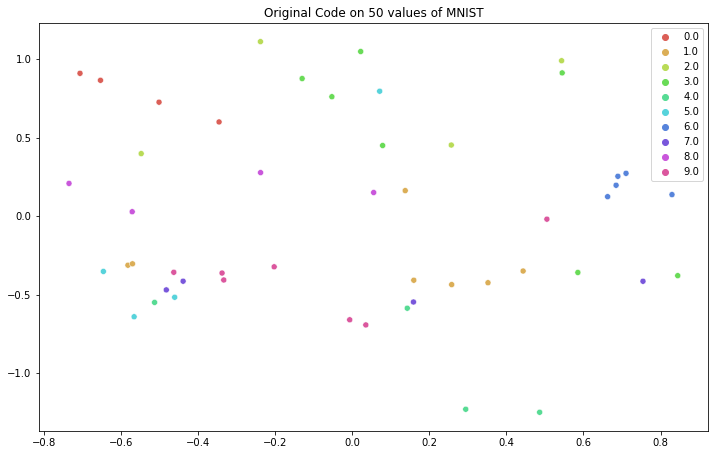

In [8]:
plt.figure(figsize=(12,7.5))
plot = sns.scatterplot(x = yout[:,0], y = yout[:,1], hue = labels[:50], palette = sns.hls_palette(10), legend = 'full');
plt.title('Original Code on 50 values of MNIST')

## Reformed and added numba JIT

In [9]:
@jit(nopython = True)
def p_ij(d_matrix, perplexity = 30.0, tol = 1e-6):
    """
    Finds P_ij matrix using binary search to find value of sigma_i

    Inputs: d_matrix- np.array of pairwise distance matrix, with a fixed perplexity

    Output: P-ij matrix
    """

    (n, d) = d_matrix.shape

    P = np.zeros((n, d), dtype=np.float64)
    prec_sum = 0.0    
    
    # precision = 1/2sigma^2
    for i in range(n):
        prec_min = -np.inf
        prec_max = np.inf
        prec = 1.0

        # implement binary search for optimal sigmas 
        for j in range(10): # 10 binary search steps
            sum_p = 0.0
            for k in range(d):
                if k != i:
                    P[i, k] = np.exp(-d_matrix[i, k] * prec)
                    sum_p += P[i, k]

            sum_p_distribution = 0.0

            for k in range(d):
                P[i, k] /= sum_p
                sum_p_distribution += d_matrix[i, k] * P[i, k]

            # Calculate entropy, H matrix
            H = np.log(sum_p) + prec * sum_p_distribution
            H_diff = H - np.log(perplexity)

            
            # check if entropy is within tolerance
            if np.fabs(H_diff) <= tol:
                break

            if H_diff > 0.0:
                prec_min = prec
                if prec_max == np.inf:
                    prec *= 2.0
                else:
                    prec = (prec + prec_max) / 2.0
            else:
                prec_max = prec
                if prec_min == -np.inf:
                    prec /= 2.0
                else:
                    prec = (prec + prec_min) / 2.0

        prec_sum += prec

    return P


@jit(nopython = True)
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    norms = np.power(X, 2).sum(axis = 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), norms).T, norms)
    
    return D

@jit(nopython = True)
def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q

@jit(nopython = True)
def grad_C(P, Q, Y):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    
    pq_diff = np.expand_dims((P - Q), 2)
    
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    
    y_dist = np.expand_dims(np.power(1 + squared_euc_dist(Y), -1), 2)

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis = 1)
    
    return grad


@jit(nopython = True)
def tsne_opt(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    D = squared_euc_dist(X)
    P = p_ij(D)
    P = P + np.transpose(P)
    P = P / np.sum(P)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y

yout2 = tsne_opt(small)

In [10]:
%timeit -r3 -n3 tsne_opt(X[:50, ])

numb = %timeit -o -r3 -n3 tsne_opt(X[:50, ])

71.7 ms ± 4.26 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
68 ms ± 2.57 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [11]:
%prun -q -D tsne_jit.prof tsne_opt(small)
p = pstats.Stats('tsne_jit.prof')
p.print_stats()
pass

 
*** Profile stats marshalled to file 'tsne_jit.prof'. 
Thu Apr 22 23:00:50 2021    tsne_jit.prof

         168 function calls (164 primitive calls) in 0.087 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        6    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x108296808}
        1    0.000    0.000    0.000    0.000 {method 'rpartition' of 'str' objects}
        1    0.000    0.000    0.087    0.087 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
    12/10    0.000    0.000    0.000    0.000 {built-in method builtins.hash}
       16    0.000    0.000    0.000    0.000 {built-in meth

Text(0.5, 1.0, 'JIT Code on 50 values of MNIST')

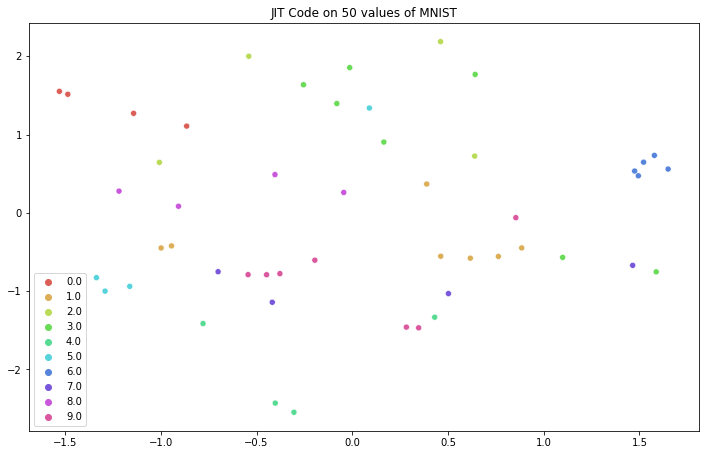

In [12]:
plt.figure(figsize=(12,7.5))
plot = sns.scatterplot(x = yout2[:,0], y = yout2[:,1], hue = labels[:50], palette = sns.hls_palette(10), legend = 'full');
plt.title('JIT Code on 50 values of MNIST')

## Cythonize

In [13]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [14]:
%%cython -a

from libc cimport math
cimport cython
import numpy as np
cimport numpy as np
from numpy cimport ndarray


@cython.boundscheck(False)
@cython.wraparound(False)
def p_ij_cy(double[:,:] d_matrix, float perplexity = 30.0, float tol = 1e-5):
    """
    Finds P_ij matrix using binary search to find value of sigmas

    Inputs: X- np.array of pairwise distance matrix, fixed perplexity

    Output: P-ij matrix
    """
    cdef int s = 10 
    
    cdef int n = d_matrix.shape[0], d = d_matrix.shape[1]
    
    cdef np.ndarray[np.float64_t, ndim=2] P = np.zeros(
        (n,d), dtype=np.float64)

    cdef float prec_sum = 0.0

    # precision = 1/2sigma^2
    for i in range(n):
        prec_min = -np.inf
        prec_max = np.inf
        prec = 1.0
        
        # implement binary search for optimal sigmas 
        for j in range(s):
            sum_p = 0.0
            for k in range(d):
                if k != i:
                    P[i, k] = np.exp(-d_matrix[i, k] * prec)
                    sum_p += P[i, k]

            sum_p_distribution = 0.0

            for k in range(d):
                P[i, k] /= sum_p
                sum_p_distribution += d_matrix[i, k] * P[i, k]

            # Calculate entropy, H matrix
            H = np.log(sum_p) + prec * sum_p_distribution
            H_diff = H - np.log(perplexity)

            if np.fabs(H_diff) <= tol:
                break

            if H_diff > 0.0:
                prec_min = prec
                if prec_max == np.inf:
                    prec *= 2.0
                else:
                    prec = (prec + prec_max) / 2.0
            else:
                prec_max = prec
                if prec_min == -np.inf:
                    prec /= 2.0
                else:
                    prec = (prec + prec_min) / 2.0

        prec_sum += prec

    return P


In [15]:
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    norms = np.power(X, 2).sum(axis = 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), norms).T, norms)
    
    return D


def q_ij(Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q


def grad_C(P, Q, Y):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    
    pq_diff = np.expand_dims((P - Q), 2)
    
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    
    y_dist = np.expand_dims(np.power(1 + squared_euc_dist(Y), -1), 2)

    grad = 4. * (pq_diff * y_diff * y_dist).sum(axis = 1)
    
    return grad


def tsne_opt2(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    D = squared_euc_dist(X)
    P = p_ij_cy(D)
    P = P + np.transpose(P)
    P = P / np.sum(P)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y

yout3 = tsne_opt2(small)

Text(0.5, 1.0, 'Cython Code on 50 values of MNIST')

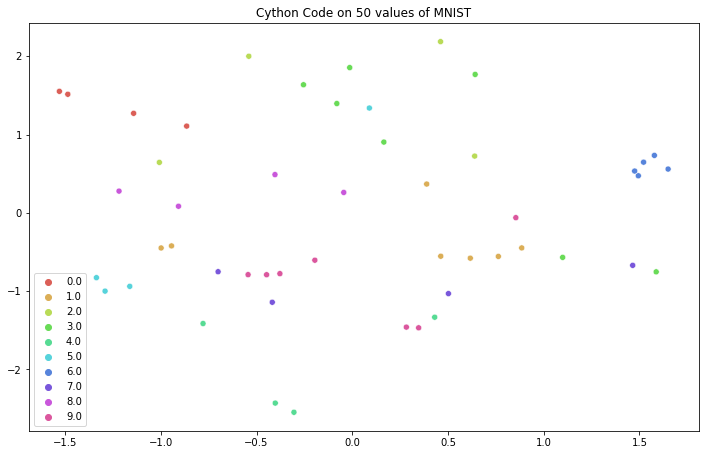

In [16]:
plt.figure(figsize=(12,7.5))
plot = sns.scatterplot(x = yout3[:,0], y = yout3[:,1], hue = labels[:50], palette = sns.hls_palette(10), legend = 'full');
plt.title('Cython Code on 50 values of MNIST')

In [17]:
%timeit -r3 -n3 tsne_opt2(X[:50, ])

cy = %timeit -o -r3 -n3 tsne_opt2(X[:50, ])

330 ms ± 5.51 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
348 ms ± 3.7 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [18]:
%prun -q -D tsne_cython1.prof tsne_opt2(small)
p = pstats.Stats('tsne_cython1.prof')
p.print_stats()
pass

 
*** Profile stats marshalled to file 'tsne_cython1.prof'. 
Thu Apr 22 23:01:02 2021    tsne_cython1.prof

         104030 function calls in 0.370 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1001    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        1    0.000    0.000    0.370    0.370 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
     5001    0.001    0.000    0.001    0.000 {built-in method builtins.isinstance}
     4000    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
    12000    0.001    0.000    0.001    0.000 {built-in method builtins.len}
     8000    0.001    0.000    0.001    0.000 {built-in method builtins.next}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
     4000    0.003    0.000    0.003    0.000 {method 'reshape' of 'numpy.ndarray' ob

In [19]:
# speed up multiplier

types = [numb, cy]
mult = list(map(lambda x: (normal.average/x.average), types))

import pandas as pd

pd.DataFrame(mult, index = ['Numba', 'Cython'], columns = ["Speed-up Multiplier"])

,Speed-up Multiplier
Numba,5.062958
Cython,0.988295


## Cythonize all functions - not working

In [20]:
%%cython -a

from libc cimport math
cimport cython
import numpy as np
cimport numpy as np
from numpy cimport ndarray
from scipy.spatial import distance


@cython.boundscheck(False)
@cython.wraparound(False)
cdef squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows.
    Output is a pairwise distance matrix D that is nxn.
    """
    cdef int n = X.shape[0]
    cdef double[:, ::1] D = np.empty((n, n), dtype=np.float64)

    
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D

In [21]:
squared_euc_dist(X)

array([[  0., 144., 206., ..., 161., 167., 163.],
       [144.,   0., 216., ..., 169., 185., 153.],
       [206., 216.,   0., ..., 177., 161., 161.],
       ...,
       [161., 169., 177., ...,   0., 184., 138.],
       [167., 185., 161., ..., 184.,   0., 156.],
       [163., 153., 161., ..., 138., 156.,   0.]])

In [22]:
%%cython -a

from libc cimport math
cimport cython
import numpy as np
cimport numpy as np
from numpy cimport ndarray

@cython.boundscheck(False)
@cython.wraparound(False)
cdef squared_euc_dist(double[:,:] X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    cdef int n = X.shape[0]
    cdef int d = X.shape[1]
    cdef double diff
    cdef double dist
    cdef double[:, ::1] D = np.empty((n, n), dtype=np.float64)
    
    for i in range(n):
        for j in range(n):
            dist = 0.0
            for k in range(d):
                diff = X[i, k] - X[j, k]
                dist += diff * diff
            D[i, j] = np.sqrt(dist)
    return np.asarray(D)


In [23]:
squared_euc_dist(X)

array([[  0., 144., 206., ..., 161., 167., 163.],
       [144.,   0., 216., ..., 169., 185., 153.],
       [206., 216.,   0., ..., 177., 161., 161.],
       ...,
       [161., 169., 177., ...,   0., 184., 138.],
       [167., 185., 161., ..., 184.,   0., 156.],
       [163., 153., 161., ..., 138., 156.,   0.]])

In [24]:
%%cython -a

from libc cimport math
cimport cython
import numpy as np
cimport numpy as np
from numpy cimport ndarray


@cython.boundscheck(False)
@cython.wraparound(False)
cdef p_ij_cy(double[:,:] d_matrix, float perplexity = 30.0, float tol = 1e-5):
    """
    Finds P_ij matrix using binary search to find value of sigmas

    Inputs: X- np.array of pairwise distance matrix, fixed perplexity

    Output: P-ij matrix
    """
    cdef int s = 10 
    
    cdef int n = d_matrix.shape[0], d = d_matrix.shape[1]
    
    cdef np.ndarray[np.float64_t, ndim=2] P = np.zeros(
        (n,d), dtype=np.float64)

    cdef float prec_sum = 0.0

    # precision = 1/2sigma^2
    for i in range(n):
        prec_min = -np.inf
        prec_max = np.inf
        prec = 1.0
        
        # implement binary search for optimal sigmas 
        for j in range(s):
            sum_p = 0.0
            for k in range(d):
                if k != i:
                    P[i, k] = np.exp(-d_matrix[i, k] * prec)
                    sum_p += P[i, k]

            sum_p_distribution = 0.0

            for k in range(d):
                P[i, k] /= sum_p
                sum_p_distribution += d_matrix[i, k] * P[i, k]

            # Calculate entropy, H matrix
            H = np.log(sum_p) + prec * sum_p_distribution
            H_diff = H - np.log(perplexity)

            if np.fabs(H_diff) <= tol:
                break

            if H_diff > 0.0:
                prec_min = prec
                if prec_max == np.inf:
                    prec *= 2.0
                else:
                    prec = (prec + prec_max) / 2.0
            else:
                prec_max = prec
                if prec_min == -np.inf:
                    prec /= 2.0
                else:
                    prec = (prec + prec_min) / 2.0

        prec_sum += prec

    return P


@cython.boundscheck(False)
@cython.wraparound(False)
cdef squared_euc_dist(double[:,::1] X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    cdef int n = X.shape[0]
    cdef int d = X.shape[1]
    cdef double diff
    cdef double dist
    cdef double[:, ::1] D = np.empty((n, n), dtype=np.float64)
    
    for i in range(n):
        for j in range(n):
            dist = 0.0
            for k in range(d):
                diff = X[i, k] - X[j, k]
                dist += diff * diff
            D[i, j] = np.sqrt(dist)
    return np.asarray(D)
    
@cython.boundscheck(False)
@cython.wraparound(False)
cdef q_ij(double[:,::1] Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    
    cdef int n = Y.shape[0]
    cdef double[:, ::1] Q = np.empty((n, n), dtype=np.float64)
    cdef double[:, ::1] numerator = np.empty((n, n), dtype=np.float64)
    
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    np.fill_diagonal(Q, 0.)
    
    return Q

In [26]:
def grad_C(P, Q, Y):
    """Estimate the gradient of t-SNE cost with respect to Y."""
        
    pq_diff = np.expand_dims((P - Q), 2)
    
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    
    y_dist = np.expand_dims(np.power(1 + squared_euc_dist(Y), -1), 2)
    
    return  4. * (pq_diff * y_diff * y_dist).sum(axis = 1)

def tsne_opt3(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    D = squared_euc_dist(X)
    P = p_ij_cy(D)
    P = P + np.transpose(P)
    P = P / np.sum(P)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y

yout3 = tsne_opt3(small)

Text(0.5, 1.0, 'Cython Code on 50 values of MNIST')

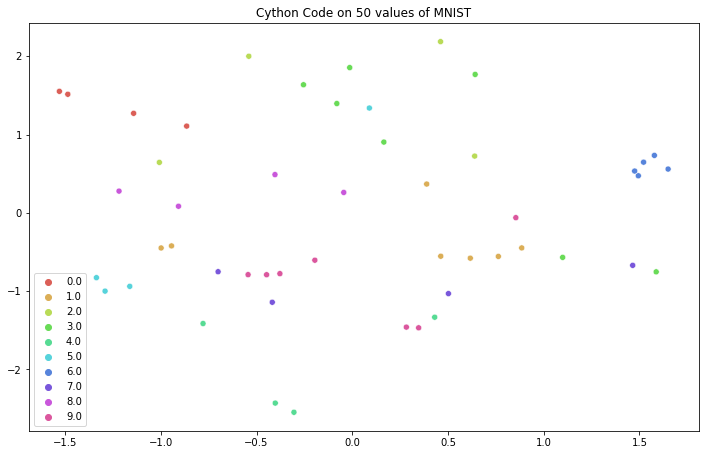

In [27]:
plt.figure(figsize=(12,7.5))
plot = sns.scatterplot(x = yout3[:,0], y = yout3[:,1], hue = labels[:50], palette = sns.hls_palette(10), legend = 'full');
plt.title('Cython Code on 50 values of MNIST')

In [28]:
%timeit -r3 -n3 tsne_opt3(X[:50, ])

cy2 = %timeit -o -r3 -n3 tsne_opt3(X[:50, ])

416 ms ± 126 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
313 ms ± 6.92 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [29]:
# speed up multiplier

types = [numb, cy, cy2]
mult = list(map(lambda x: (normal.average/x.average), types))

import pandas as pd

pd.DataFrame(mult, index = ['Numba', 'Cython1', 'Cython2'], columns = ["Speed-up Multiplier"])

,Speed-up Multiplier
Numba,5.062958
Cython1,0.988295
Cython2,1.097772


### Cython all functions: mady

In [30]:
%%cython -a

from libc cimport math
cimport cython
import numpy as np
cimport numpy as np
from numpy cimport ndarray
from scipy.spatial import distance


@cython.boundscheck(False)
@cython.wraparound(False)
def squared_euc_dist(X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows.
    Output is a pairwise distance matrix D that is nxn.
    """
    cdef int n = X.shape[0]
    cdef double[:, ::1] D = np.empty((n, n), dtype=np.float64)

    
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    return D

In [31]:
%%cython -a

from libc cimport math
cimport cython
import numpy as np
cimport numpy as np
from numpy cimport ndarray

@cython.boundscheck(False)
@cython.wraparound(False)
def squared_euc_dist(double[:,:] X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    cdef int n = X.shape[0]
    cdef int d = X.shape[1]
    cdef double diff
    cdef double dist
    cdef double[:, ::1] D = np.empty((n, n), dtype=np.float64)
    
    for i in range(n):
        for j in range(n):
            dist = 0.0
            for k in range(d):
                diff = X[i, k] - X[j, k]
                dist += diff * diff
            D[i, j] = np.sqrt(dist)
    return np.asarray(D)


In [32]:
%%cython -a

from libc cimport math
cimport cython
import numpy as np
cimport numpy as np
from numpy cimport ndarray


@cython.boundscheck(False)
@cython.wraparound(False)
def p_ij_cy(double[:,:] d_matrix, float perplexity = 30.0, float tol = 1e-5):
    """
    Finds P_ij matrix using binary search to find value of sigmas

    Inputs: X- np.array of pairwise distance matrix, fixed perplexity

    Output: P-ij matrix
    """
    cdef int s = 10 
    
    cdef int n = d_matrix.shape[0], d = d_matrix.shape[1]
    
    cdef np.ndarray[np.float64_t, ndim=2] P = np.zeros(
        (n,d), dtype=np.float64)

    cdef float prec_sum = 0.0

    # precision = 1/2sigma^2
    for i in range(n):
        prec_min = -np.inf
        prec_max = np.inf
        prec = 1.0
        
        # implement binary search for optimal sigmas 
        for j in range(s):
            sum_p = 0.0
            for k in range(d):
                if k != i:
                    P[i, k] = np.exp(-d_matrix[i, k] * prec)
                    sum_p += P[i, k]

            sum_p_distribution = 0.0

            for k in range(d):
                P[i, k] /= sum_p
                sum_p_distribution += d_matrix[i, k] * P[i, k]

            # Calculate entropy, H matrix
            H = np.log(sum_p) + prec * sum_p_distribution
            H_diff = H - np.log(perplexity)

            if np.fabs(H_diff) <= tol:
                break

            if H_diff > 0.0:
                prec_min = prec
                if prec_max == np.inf:
                    prec *= 2.0
                else:
                    prec = (prec + prec_max) / 2.0
            else:
                prec_max = prec
                if prec_min == -np.inf:
                    prec /= 2.0
                else:
                    prec = (prec + prec_min) / 2.0

        prec_sum += prec

    return P


@cython.boundscheck(False)
@cython.wraparound(False)
def squared_euc_dist(double[:,::1] X):
    """Calculate squared euclidean distance for all pairs in a data matrix X with d dimensions and n rows. 
    Output is a pairwise distance matrix D that is nxn.
    """
    cdef int n = X.shape[0]
    cdef int d = X.shape[1]
    cdef double diff
    cdef double dist
    cdef double[:, ::1] D = np.empty((n, n), dtype=np.float64)
    
    for i in range(n):
        for j in range(n):
            dist = 0.0
            for k in range(d):
                diff = X[i, k] - X[j, k]
                dist += diff * diff
            D[i, j] = np.sqrt(dist)
    return np.asarray(D)
    
@cython.boundscheck(False)
@cython.wraparound(False)
def q_ij(double[:,::1] Y):
    """Calculate joint probabilities over all points given Y, the low-dimensional map of data points. (pg. 2585)"""
    
    
    cdef int n = Y.shape[0]
    cdef double[:, ::1] Q = np.empty((n, n), dtype=np.float64)
    cdef double[:, ::1] numerator = np.empty((n, n), dtype=np.float64)
    
    
    numerator = np.power(1. + (squared_euc_dist(Y)), -1)
    Q = numerator / np.sum(numerator)
    
    # q_i|i = 0
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            if i==j:
                Q[i,j] = 0
    
    return Q

In [33]:
def grad_C(P, Q, Y):
    """Estimate the gradient of t-SNE cost with respect to Y."""
        
    pq_diff = np.expand_dims((P - Q), 2)
    
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    
    y_dist = np.expand_dims(np.power(1 + squared_euc_dist(Y), -1), 2)
    
    return  4. * (pq_diff * y_diff * y_dist).sum(axis = 1)

def tsne_opt3(X, num_iters = 1000, perplexity = 30, alpha = 10, momentum = 0.9):
    """Calculate Y, the optimal low-dimensional representation of data matrix X using optimized TSNE.
    
    Inputs: 
        X: data matrix 
        num_iters: number of iterations 
        perplexity: target perplexity for calculating optimal sigmas for P probability matrix
        alpha: learning rate
        momentum: momentum to speed up gradient descent algorithm 
    """

    # Initialize Y 
    np.random.seed(0)
    Y = np.random.normal(0, 0.0001, size=(X.shape[0], 2))
    D = squared_euc_dist(X)
    P = p_ij_cy(D)
    P = P + np.transpose(P)
    P = P / np.sum(P)

    # Initialise past y_t-1 and y_t-2 values (used for momentum)
    Y_tmin2 = Y
    Y_tmin1 = Y

    # gradient descent with momentum
    for i in range(num_iters):

        Q = q_ij(Y)
        grad = grad_C(P, Q, Y)

        # Update Y using momentum (pg. 2587)
        Y = (Y - (alpha * grad)) +  (momentum * (Y_tmin1 - Y_tmin2))
  
        # update values of y_t-1 and y_t-2
        Y_tmin2 = Y_tmin1
        Y_tmin1 = Y

    return Y

yout3 = tsne_opt3(small)

In [34]:
%timeit -r3 -n3 tsne_opt3(X[:50, ])

cy2 = %timeit -o -r3 -n3 tsne_opt3(X[:50, ])

3.18 s ± 36.9 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
3.24 s ± 52.5 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


Text(0.5, 1.0, 'Cython Code on 50 values of MNIST')

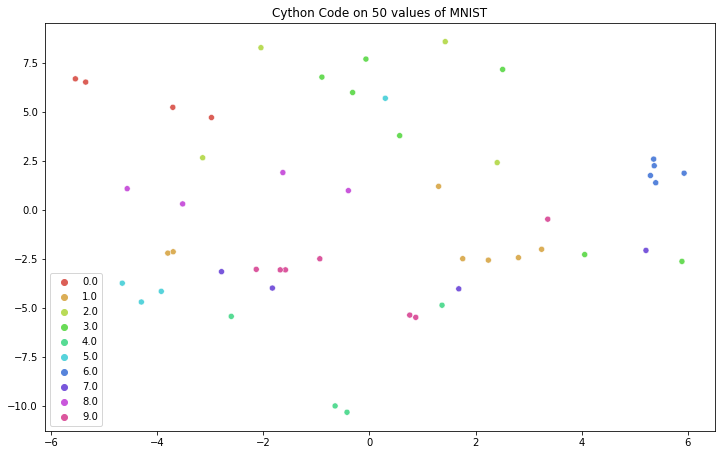

In [35]:
plt.figure(figsize=(12,7.5))
plot = sns.scatterplot(x = yout3[:,0], y = yout3[:,1], hue = labels[:50], palette = sns.hls_palette(10), legend = 'full');
plt.title('Cython Code on 50 values of MNIST')